# Check class balancing of CamVid train data set  

In [1]:
# packages and modules
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from tqdm.notebook import tqdm

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Load Data

In [4]:
# 클래스 디렉토리 데이터 불러오기
data = pd.read_csv(r'C:\Users\user\MY_DL\segmentation\dataset\camvid_low\11_class_dict.csv', index_col=0)

rgb_data = {name:list(data.loc[name, :][:3]) for name in data.index}
rgb_array = {idx:np.array(rgb) for idx, (_, rgb) in enumerate(rgb_data.items())}

data

,r,g,b
name,,,
Sky,128,128,128
Building,128,0,0
Pole,192,192,128
Road,128,64,128
Sidewalk,0,0,192
Tree,128,128,0
SignSymbol,192,128,128
Fence,64,64,128
Car,64,0,128


In [5]:
width = 480
height = 360
num_classes = len(data)

In [6]:
def load_image(path, subset='train'):
    image_list, label_list = [], []
    image_files = glob(path+subset+'/'+subset+'_images/*.png')
    label_files = glob(path+subset+'/'+subset+'_labels/*.png')
    for file in tqdm(image_files):
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        image_list.append(img)
    for file in tqdm(label_files):
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        label_list.append(img)
    return np.array(image_list), np.array(label_list)

path = 'C:/Users/user/MY_DL/segmentation/dataset/camvid_low/'
train_image, train_label = load_image(path, subset='train')
valid_image, valid_label = load_image(path, subset='valid')
test_image, test_label = load_image(path, subset='test')

  0%|          | 0/367 [00:00<?, ?it/s]

  0%|          | 0/367 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/233 [00:00<?, ?it/s]

  0%|          | 0/233 [00:00<?, ?it/s]

In [8]:
def get_class_total_num(class_name, data_label):
    class_count = 0
    for i in tqdm(range(len(data_label))):
        for j in range(data_label.shape[1]):
            for k in range(data_label.shape[2]):
                if (data_label[i][j,k,:] == rgb_data[class_name]).sum() == 3:
                    class_count += 1
    return class_count

In [9]:
# check counting of train data
Sky = get_class_total_num('Sky', train_label)
Building = get_class_total_num('Building', train_label)
Pole = get_class_total_num('Pole', train_label)
Road = get_class_total_num('Road', train_label)
Sidewalk = get_class_total_num('Sidewalk', train_label)
Tree = get_class_total_num('Tree', train_label)
SignSymbol = get_class_total_num('SignSymbol', train_label)
Fence = get_class_total_num('Fence', train_label)
Car = get_class_total_num('Car', train_label)
Pedestrian = get_class_total_num('Pedestrian', train_label)
Bicyclist = get_class_total_num('Bicyclist', train_label)
unlabelled = get_class_total_num('unlabelled', train_label)

  0%|          | 0/367 [00:00<?, ?it/s]

  0%|          | 0/367 [00:00<?, ?it/s]

  0%|          | 0/367 [00:00<?, ?it/s]

  0%|          | 0/367 [00:00<?, ?it/s]

  0%|          | 0/367 [00:00<?, ?it/s]

  0%|          | 0/367 [00:00<?, ?it/s]

  0%|          | 0/367 [00:00<?, ?it/s]

  0%|          | 0/367 [00:00<?, ?it/s]

  0%|          | 0/367 [00:00<?, ?it/s]

  0%|          | 0/367 [00:00<?, ?it/s]

  0%|          | 0/367 [00:00<?, ?it/s]

  0%|          | 0/367 [00:00<?, ?it/s]

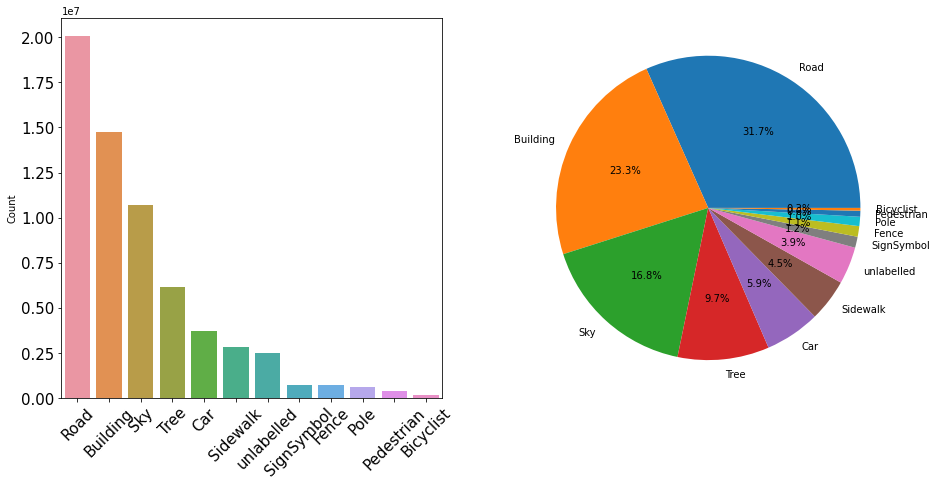

In [10]:
# create data frame
train_class_labels = list(rgb_data.keys())
train_class_count = [Sky, Building, Pole, Road, Sidewalk, Tree, SignSymbol, Fence, Car,
                     Pedestrian, Bicyclist, unlabelled]

train_class_df = pd.DataFrame(train_class_count, index=train_class_labels, columns=['Count'])
train_class_df = train_class_df.sort_values(by='Count', ascending=False)

# show plots
plt.figure(figsize=(15,7))
plt.subplot(121)
sns.barplot(data=train_class_df, x=train_class_df.index, y='Count')
plt.xticks(rotation=45, fontsize=15)
plt.yticks(fontsize=15)
plt.subplot(122)
plt.pie(train_class_df['Count'], labels=train_class_df.index, autopct='%.1f%%')
plt.show()

- data imbalance가 굉장히 심하다  
- 위의 그래프를 보면 train data의 경우 Road, Building, Sky, Tree가 총 약 80%를 차지하고 있고   
- 단순히 Cross Entropy Loss를 사용할 경우 작은 object에 대해서는 segmentation을 수행을 못하게 됨   
- 그래서 Loss function의 수정이 필요함  
- 논문에서는 median frequency balancing라는 것을 이용해 Cross Entropy Loss 연산 과정에서 각 클래스에 weight를 부여함